In [ ]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
import pyarrow.parquet as pq
table= pq.read_table('/content/df_final.parquet')
df = table.to_pandas()

In [ ]:
df.head()

,prdtypecode,product_class,merged_text,merged_imageid
0,10,livres_adulte,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg
1,2280,magazines,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg
2,50,accessoires_jeux_videos,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg
3,1280,jouets_enfance,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg
4,2705,livres_et_illustres,La Guerre Des Tuques Luc a des id&eacute;es de...,image_1077757786_product_278535884.jpg


In [ ]:
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('floresta')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Package floresta is already up-to-date!


True

In [ ]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

sw = set(stopwords.words(['english', 'french']))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def processing_text(row):

    soup = BeautifulSoup(row, 'html.parser')   # Remove HTML tags using BeautifulSoup
    cleaned_text = soup.get_text()


    cleaned_text = re.sub(r"[^a-zA-ZÀ-ÿàâçéèêëîïôûùüÿœ\s]", "", cleaned_text)  # Remove special characters and non-alphanumeric characters


    tokens = word_tokenize(cleaned_text) # Tokenize the cleaned text


    stop_words_removed = [word for word in tokens if word.lower() not in sw and len(word) > 2] # Remove stopwords and filter words that 2 letters or less.

    # Lemmatize and convert to lowercase
    filtered_text = [lemmatizer.lemmatize(word).lower() for word in stop_words_removed]
     # return filtered_text
    return ' '.join(filtered_text)



In [ ]:
df.shape

(84916, 4)

In [ ]:
X = df.merged_text
y = df.product_class

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the label encoder on your target labels and transform them
y_le = label_encoder.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size=0.2, random_state=1234)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((67932,), (16984,), (67932,), (16984,))

In [ ]:

X_train = X_train.apply(processing_text)
X_test = X_test.apply(processing_text)

<ipython-input-92-f5d99f5e691c>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(row, 'html.parser')   # Remove HTML tags using BeautifulSoup


In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
sentences = [sentence.split() for sentence in X_train]

w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

In [ ]:
word_list = list(w2v_model.wv.index_to_key)

In [ ]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [ ]:
import numpy as np

# Save the processed data to files
np.save("X_train_text.npy", X_train)
np.save("X_test_text.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)


In [ ]:
import shutil

# Source directory where you saved the processed data
source_dir = '/content/'

# Destination directory in your Google Drive
destination_dir = '/content/drive/MyDrive/new_rakuten'

# Copy the files to Google Drive
shutil.copy(source_dir + 'X_train_image.npy', destination_dir)
shutil.copy(source_dir + 'X_test_image.npy', destination_dir)
shutil.copy(source_dir + 'y_train.npy', destination_dir)
shutil.copy(source_dir + 'y_test.npy', destination_dir)

In [ ]:
# Define the CNN model
word2vec_model = Sequential()
word2vec_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
word2vec_model.add(Conv1D(128, 5, activation='relu'))
word2vec_model.add(MaxPooling1D(5))
word2vec_model.add(Conv1D(128, 5, activation='relu'))
word2vec_model.add(MaxPooling1D(5))

word2vec_model.add(Flatten())
word2vec_model.add(Dense(128, activation='relu'))
word2vec_model.add(Dropout(0.5))
word2vec_model.add(Dense(64, activation = 'relu'))

word2vec_model.add(Dense(27, activation='softmax'))

In [ ]:
word2vec_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
word2vec_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          16747800  
                                                                 
 conv1d_14 (Conv1D)          (None, 96, 128)           64128     
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 19, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_15 (Conv1D)          (None, 15, 128)           82048     
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 3, 128)            0         
 ng1D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 384)              

In [ ]:
histrory = word2vec_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
2123/2123 [==============================] - 91s 43ms/step - loss: 1.4963 - accuracy: 0.5572 - val_loss: 1.0946 - val_accuracy: 0.6767
Epoch 2/10
2123/2123 [==============================] - 79s 37ms/step - loss: 1.1017 - accuracy: 0.6731 - val_loss: 1.0281 - val_accuracy: 0.6919
Epoch 3/10
2123/2123 [==============================] - 83s 39ms/step - loss: 0.9855 - accuracy: 0.7041 - val_loss: 0.9914 - val_accuracy: 0.7024
Epoch 4/10
2123/2123 [==============================] - 83s 39ms/step - loss: 0.9089 - accuracy: 0.7238 - val_loss: 0.9870 - val_accuracy: 0.7060
Epoch 5/10
2123/2123 [==============================] - 77s 36ms/step - loss: 0.8499 - accuracy: 0.7416 - val_loss: 0.9512 - val_accuracy: 0.7150
Epoch 6/10
2123/2123 [==============================] - 78s 37ms/step - loss: 0.8043 - accuracy: 0.7522 - val_loss: 0.9882 - val_accuracy: 0.7123
Epoch 7/10
2123/2123 [==============================] - 78s 37ms/step - loss: 0.7639 - accuracy: 0.7651 - val_loss: 0.9618 -

In [ ]:
from tensorflow.keras.models import Model
word2vec_model.save('best_word2vec_nn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


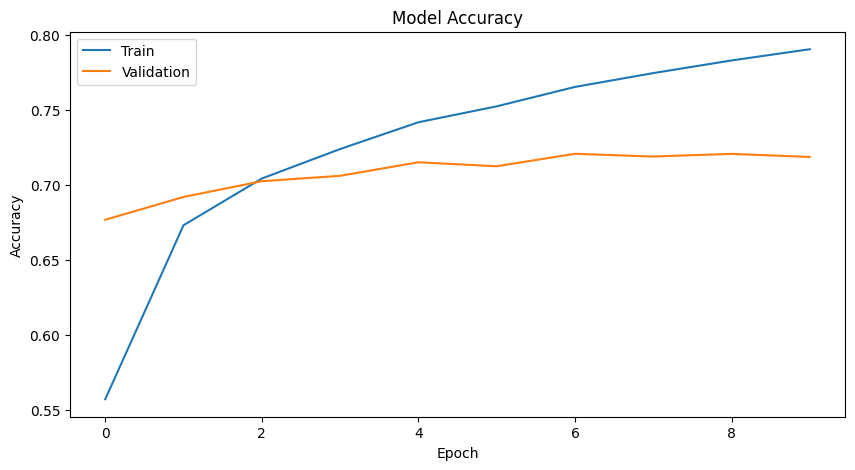

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(histrory.history['accuracy'])
plt.plot(histrory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

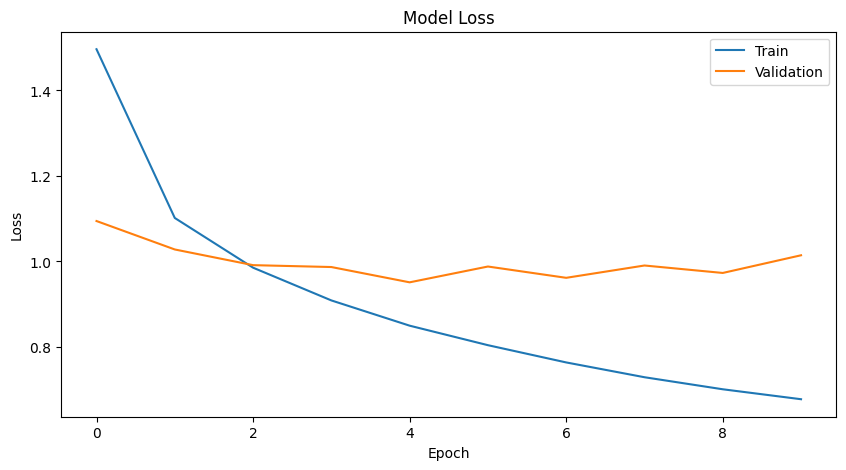

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(histrory.history['loss'])
plt.plot(histrory.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
import joblib

# Save the Word2Vec model
joblib.dump(w2v_model, "word2vec_model.pkl")

# Load the Word2Vec model
# loaded_model = joblib.load("word2vec_model.pkl")

['word2vec_model.pkl']

In [ ]:
import joblib

# Save the fitted tokenizer
joblib.dump(tokenizer, "w2v_tokenizer.pkl")

# Load the fitted tokenizer
# loaded_tokenizer = joblib.load("w2v_tokenizer.pkl")

['w2v_tokenizer.pkl']

In [ ]:
# Define the CNN model
word2vec_model = Sequential()
word2vec_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
word2vec_model.add(Conv1D(128, 5, activation='relu'))
word2vec_model.add(MaxPooling1D(5))
word2vec_model.add(Conv1D(128, 5, activation='relu'))
word2vec_model.add(MaxPooling1D(5))

word2vec_model.add(Flatten())
word2vec_model.add(Dense(128, activation='relu'))
word2vec_model.add(Dropout(0.5))
word2vec_model.add(Dense(64, activation = 'relu'))

word2vec_model.add(Dense(27, activation='softmax'))

In [ ]:
word2vec_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
word2vec_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 100)          16747800  
                                                                 
 conv1d_27 (Conv1D)          (None, 96, 128)           64128     
                                                                 
 max_pooling1d_26 (MaxPooli  (None, 19, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, 15, 128)           82048     
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 3, 128)            0         
 ng1D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 384)             

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'image_model' is your Keras model
plot_model(word2vec_model, to_file='image_model.png', show_shapes=True)

In [ ]:
word2vec_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
2123/2123 [==============================] - 50s 23ms/step - loss: 1.5026 - accuracy: 0.5560 - val_loss: 1.0791 - val_accuracy: 0.6756
Epoch 2/10
2123/2123 [==============================] - 48s 23ms/step - loss: 1.0990 - accuracy: 0.6726 - val_loss: 1.0376 - val_accuracy: 0.6909
Epoch 3/10
2123/2123 [==============================] - 48s 23ms/step - loss: 0.9865 - accuracy: 0.7054 - val_loss: 0.9799 - val_accuracy: 0.7051
Epoch 4/10
2123/2123 [==============================] - 49s 23ms/step - loss: 0.9097 - accuracy: 0.7277 - val_loss: 0.9691 - val_accuracy: 0.7160
Epoch 5/10
2123/2123 [==============================] - 48s 23ms/step - loss: 0.8524 - accuracy: 0.7414 - val_loss: 0.9517 - val_accuracy: 0.7193
Epoch 6/10
2123/2123 [==============================] - 48s 23ms/step - loss: 0.8047 - accuracy: 0.7539 - val_loss: 0.9489 - val_accuracy: 0.7228
Epoch 7/10
2123/2123 [==============================] - 49s 23ms/step - loss: 0.7658 - accuracy: 0.7656 - val_loss: 0.9766 -

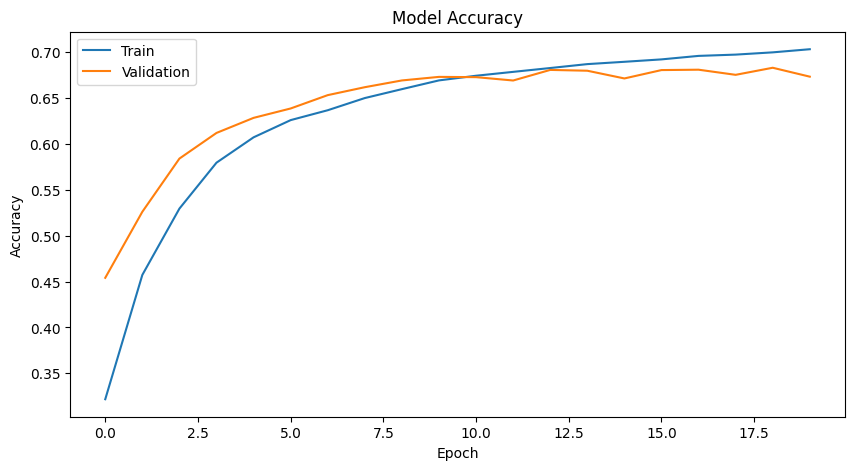

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

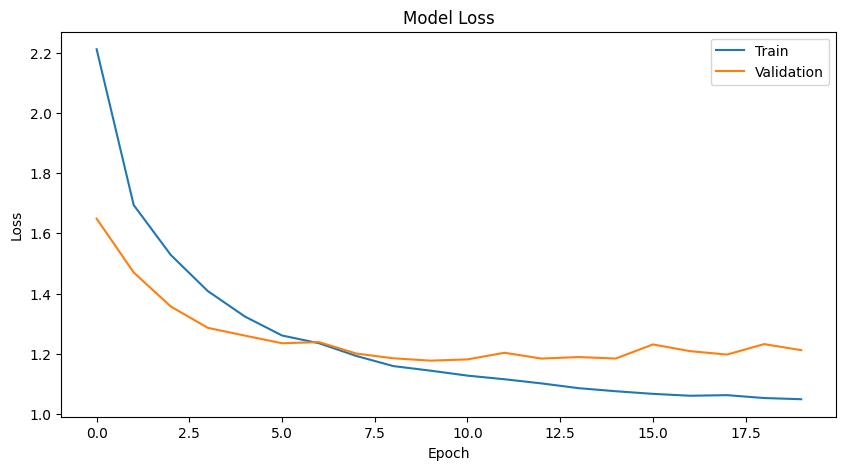

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from tensorflow.keras.models import Model
word2vec_model.save('best_word2vec_nn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
